In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
from torch import nn
from pytorch_forecasting.metrics import MAE, MAPE, MASE, RMSE, SMAPE, MultiHorizonMetric, MultiLoss, QuantileLoss

from collections import namedtuple
import copy
from copy import deepcopy
import inspect
import logging
import os
from typing import Any, Callable, Dict, Iterable, List, Literal, Optional, Tuple, Union
import warnings

import lightning.pytorch as pl
from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.callbacks import BasePredictionWriter, LearningRateFinder
from lightning.pytorch.trainer.states import RunningStage
from lightning.pytorch.utilities.parsing import AttributeDict, get_init_args
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.function_base import iterable
import pandas as pd
import pytorch_optimizer
from pytorch_optimizer import Ranger21
import scipy.stats
import torch
import torch.nn as nn
from torch.nn.utils import rnn
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
import yaml
from lightning.pytorch.utilities import rank_zero_only

from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import EncoderNormalizer, GroupNormalizer, MultiNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import (
    MAE,
    MASE,
    SMAPE,
    DistributionLoss,
    MultiHorizonMetric,
    MultiLoss,
    QuantileLoss,
    convert_torchmetric_to_pytorch_forecasting_metric,
)
from pytorch_forecasting.metrics.base_metrics import Metric
from pytorch_forecasting.models.nn.embeddings import MultiEmbedding
from pytorch_forecasting.utils import (
    InitialParameterRepresenterMixIn,
    OutputMixIn,
    TupleOutputMixIn,
    apply_to_list,
    concat_sequences,
    create_mask,
    get_embedding_size,
    groupby_apply,
    to_list,
)
from copy import copy
from typing import Dict, List, Tuple, Union

from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
from torchmetrics import Metric as LightningMetric

from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, MAPE, MASE, RMSE, SMAPE, MultiHorizonMetric, MultiLoss, QuantileLoss
from pytorch_forecasting.models.base_model import BaseModelWithCovariates
from pytorch_forecasting.models.nn import LSTM, MultiEmbedding
from pytorch_forecasting.models.temporal_fusion_transformer.sub_modules import (
    AddNorm,
    GateAddNorm,
    GatedLinearUnit,
    GatedResidualNetwork,
    InterpretableMultiHeadAttention,
    VariableSelectionNetwork,
)
from pytorch_forecasting.utils import create_mask, detach, integer_histogram, masked_op, padded_stack, to_list
import pandas as pd
import matplotlib.pyplot as plt
import csv
import statsmodels
import random

from statsmodels.tsa.seasonal import STL

import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting import GroupNormalizer
from pytorch_forecasting import Baseline
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting import GroupNormalizer
from pytorch_forecasting import Baseline
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics.quantile import QuantileLoss
from lightning.pytorch.callbacks import ModelCheckpoint
import pickle
import math


/Users/charansr/model_training/venv/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:

#important constants
workernum =4
batch_size = 16
brave_workers = False
pinmem=False
marsh_coeff=50
schnider_coeff=200
eleveld_coeff=100
thresh=0.8


def append_string_to_txt(string_to_append, file_path):
    try:
        with open(file_path, 'a') as file:
            file.write(string_to_append)
        #print(f'String appended to {file_path} successfully.')
    except Exception as e:
        #print(f'Error: {e}')
        pass


In [4]:
def display_model():
    test_df=final_df[final_df["caseid"]== 14]
    test_df=test_df[600:]
    test_df.reset_index(inplace=True,drop=True)
    test = TimeSeriesDataSet(
        test_df,
        time_idx="time",
        target="Orchestra/PPF20_RATE",
        group_ids=["caseid"],
        min_encoder_length=max_encoder_length // 2, 
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=static_cat,
        static_reals=static_tracks,
        time_varying_known_reals=time_varying_known,
        time_varying_unknown_reals=time_varying_notknown,
        target_normalizer=GroupNormalizer(
            groups=["caseid"], transformation="softplus"
        ),  # we normalize by group
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True
    )

    test_dataloader = test.to_dataloader(train=False, batch_size=1, num_workers=1, persistent_workers=False,pin_memory=False)
    #predictions = tft.predict(test_dataloader, return_y=True, fast_dev_run=True,trainer_kwargs=dict(accelerator="mps"),mode_kwargs=dict(quantile_value="0.9"))
    #rawpred=tft.predict(test_dataloader,mode="raw", return_x=True,fast_dev_run=True,trainer_kwargs=dict(accelerator="mps"))
    #plt.plot(rawpred.output["prediction"][0][:,5].cpu())
    #plt.plot(predictions.y[0].squeeze().cpu())
    rawpred=tft.predict(test_dataloader,mode="raw", return_x=True,fast_dev_run=True,trainer_kwargs=dict(accelerator="mps"))
    rawpred.output["prediction"][0][:,3]=rawpred.output["prediction"][0][:,5]
    tft.plot_prediction(rawpred.x, rawpred.output, idx=0, add_loss_to_title=False,plot_attention=True)

In [5]:

final_df = pd.read_csv("/Users/charansr/model_training/tuningdf_pkpkd27.csv")
print("df imported")

if("Unnamed: 0.1" in final_df.columns):
    final_df=final_df.drop("Unnamed: 0.1",axis=1)
    print("dropped")

if("Unnamed: 0" in final_df.columns):
    final_df=final_df.drop("Unnamed: 0",axis=1)
    print("dropped")

if("Unnamed: 0.2" in final_df.columns):
    final_df=final_df.drop("Unnamed: 0.2",axis=1)
    print("dropped")


tar_mean=(final_df["Orchestra/PPF20_RATE"]).mean()
tar_std=(final_df["Orchestra/PPF20_RATE"]).std()

condition = final_df["Orchestra/PPF20_RATE"] > (tar_mean + (thresh * tar_std))

final_df["InfusionSpikes"]=condition.apply(lambda x: 1 if x else 0)

df imported
dropped
dropped


In [6]:

columns=["time","caseid","Orchestra/PPF20_CP","Orchestra/PPF20_CT","Orchestra/PPF20_RATE","Orchestra/PPF20_CE","Orchestra/RFTN20_CP","Orchestra/RFTN20_CT","Orchestra/RFTN20_RATE","Orchestra/RFTN20_CE","BIS/BIS","Solar8000/HR","Solar8000/PLETH_SPO2","Solar8000/ART_MBP","Solar8000/ART_SBP","Solar8000/BT","casestart","anestart","opstart","age","sex","height","weight","bmi","asa","optype","dx","opname","ane_type","preop_dm","Marsh","Schnider","Eleveld"]
static_tracks=["casestart","anestart","opstart","age","height","weight","bmi","asa","preop_dm"]
static_cat=["sex","optype","dx","opname","ane_type"]
time_varying_known=["Orchestra/PPF20_CT","Orchestra/RFTN20_CT","Marsh","Schnider","Eleveld","InfusionSpikes"]
time_varying_notknown=["Orchestra/PPF20_RATE","Orchestra/PPF20_CP","Orchestra/PPF20_CE","Orchestra/RFTN20_CP","Orchestra/RFTN20_CE","Orchestra/RFTN20_RATE","Solar8000/HR","Solar8000/PLETH_SPO2","Solar8000/ART_MBP","Solar8000/ART_SBP","Solar8000/BT","BIS/BIS"]

final_df.reset_index(drop=True,inplace=True)
final_df[static_tracks]=final_df[static_tracks].astype("float")
final_df[time_varying_known]=final_df[time_varying_known].astype("float")
final_df[time_varying_notknown]=final_df[time_varying_notknown].astype("float")
final_df["time"]=final_df["time"].astype(int)
final_df[static_cat]=final_df[static_cat].astype(str)
final_df=final_df.dropna()
final_df.reset_index(drop=True,inplace=True)

final_df["Marsh"]=final_df["Marsh"]*marsh_coeff
final_df["Schnider"]=final_df["Schnider"]*schnider_coeff
final_df["Eleveld"]=final_df["Eleveld"]*eleveld_coeff

In [7]:
with open("/Users/charansr/model_training/train_caseids.pkl", 'rb') as file:
    traincas = pickle.load(file)

traincas = [caseid for caseid in traincas]
traincas.sort()
traincas=traincas[0:3]
train_df=final_df[final_df["caseid"].isin(traincas)]

#train_df=final_df[final_df["caseid"]==34]
train_df["InfusionSpikes"]=train_df["InfusionSpikes"].astype("Int64")

with open("/Users/charansr/model_training/val_caseids.pkl", 'rb') as file:
    valcas = pickle.load(file)

valcas = [caseid for caseid in valcas if caseid < 1008]
valcas.sort()
valcas=valcas[0:1]
val_df=final_df[final_df["caseid"].isin(valcas)]
#val_df=final_df[final_df["caseid"]==16]


val_df=val_df.reset_index(drop=True)
train_df=train_df.reset_index(drop=True)

/var/folders/3s/hcbtx1hn1cs7zkby2nr_hyp80000gn/T/ipykernel_97976/2179078893.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["InfusionSpikes"]=train_df["InfusionSpikes"].astype("Int64")


In [8]:

max_prediction_length = 200
max_encoder_length = 600
#training_cutoff = final_df["time"].max() - max_prediction_length

training = TimeSeriesDataSet(
    train_df,
    time_idx="time",
    target="Orchestra/PPF20_RATE",
    group_ids=["caseid"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=static_cat,
    static_reals=static_tracks,
    time_varying_known_reals=time_varying_known,
    time_varying_unknown_reals=time_varying_notknown,
    target_normalizer=GroupNormalizer(
        groups=["caseid"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)
print("Training Dataset Created(177)")

# create dataloaders for  our model

# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=workernum, persistent_workers=brave_workers,pin_memory=pinmem)

Training Dataset Created(177)


In [9]:

validation = TimeSeriesDataSet(
    val_df,
    time_idx="time",
    target="Orchestra/PPF20_RATE",
    group_ids=["caseid"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=static_cat,
    static_reals=static_tracks,
    time_varying_known_reals=time_varying_known,
    time_varying_unknown_reals=time_varying_notknown,
    target_normalizer=GroupNormalizer(
        groups=["caseid"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)
print("Validation Dataset Created(219)")

val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=workernum, persistent_workers=brave_workers,pin_memory=pinmem)

print("Dataloaders created(223)")


Validation Dataset Created(219)
Dataloaders created(223)


In [10]:

best_checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',  # Choose a metric to monitor (e.g., validation loss)
    dirpath='/home/sridhar/out_dev1/checkpoints/',  # Directory to save checkpoints
    filename='best_model-{epoch:02d}-{val_loss:.2f}',  # Naming pattern for saved checkpoints
    save_top_k=1,  # Save only the best model
    every_n_epochs=1,
    mode='min',  # 'min' if monitoring validation loss, 'max' if monitoring validation accuracy
)
all_checkpoint_callback = ModelCheckpoint(
    dirpath='/home/sridhar/out_dev1/checkpoints/',  # Directory to save checkpoints
    filename='all_model-{epoch:02d}-{val_loss:.2f}',  # Naming pattern for saved checkpoints
    save_top_k=-1,
    every_n_epochs=1
)


In [11]:


class metric_record(pl.callbacks.Callback):
    
    def on_epoch_start(self, trainer, pl_module):
        print(trainer.current_epoch)
        newep=str(trainer.current_epoch)
        newep+="\n"
        append_string_to_txt(newep,"/home/sridhar/out_dev1/output.txt")
        #print(pl_module.logging_metrics)
        #print(trainer.callback_metrics)
        """for metric in pl_module.logging_metrics:
            metric_name = metric.__class__.__name__
            value = trainer.callback_metrics.get(metric_name, None)
            print(f'{metric_name}: {value}')
            a=f'{metric_name}: {value}\n'
            append_string_to_txt(a,"output.txt")"""

In [12]:
  

class custom_tft(TemporalFusionTransformer):
    def log_metrics(
        self,
        x: Dict[str, torch.Tensor],
        y: torch.Tensor,
        out: Dict[str, torch.Tensor],
        prediction_kwargs: Dict[str, Any] = None,
    ) -> None:
        """
        Log metrics every training/validation step.

        Args:
            x (Dict[str, torch.Tensor]): x as passed to the network by the dataloader
            y (torch.Tensor): y as passed to the loss function by the dataloader
            out (Dict[str, torch.Tensor]): output of the network
            prediction_kwargs (Dict[str, Any]): parameters for ``to_prediction()`` of the loss metric.
        """
        # logging losses - for each target
        if prediction_kwargs is None:
            prediction_kwargs = {}
        y_hat_point = self.to_prediction(out, **prediction_kwargs)
        if isinstance(self.loss, MultiLoss):
            y_hat_point_detached = [p.detach() for p in y_hat_point]
        else:
            y_hat_point_detached = [y_hat_point.detach()]

        for metric in self.logging_metrics:
            for idx, y_point, y_part, encoder_target in zip(
                list(range(len(y_hat_point_detached))),
                y_hat_point_detached,
                to_list(y[0]),
                to_list(x["encoder_target"]),
            ):
                y_true = (y_part, y[1])
                if isinstance(metric, MASE):
                    loss_value = metric(
                        y_point, y_true, encoder_target=encoder_target, encoder_lengths=x["encoder_lengths"]
                    )
                else:
                    loss_value = metric(y_point, y_true)
                if len(y_hat_point_detached) > 1:
                    target_tag = self.target_names[idx] + " "
                else:
                    target_tag = ""
                    
                    #CUSTOM PART START
                    #print(f"{target_tag}{self.current_stage}_{metric.name}",": ",loss_value)
                    save_string = "{}{}_{}: {}".format(target_tag, self.current_stage, metric.name, loss_value)
                    save_string+="\n"
                    append_string_to_txt(save_string,"/home/sridhar/out_dev1/output.txt")
                    # CUSTOM PART END
                    
                    self.log(
                    f"{target_tag}{self.current_stage}_{metric.name}",
                    loss_value,
                    on_step=self.training,
                    on_epoch=True,
                    batch_size=len(x["decoder_target"]),
                    sync_dist=True
                )


In [13]:

spike_coeff=3000000 
class custom_quantile_loss(QuantileLoss):
     def loss(self, y_pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        # calculate quantile loss
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - y_pred[..., i]
            quantile_loss = torch.max((q - 1) * errors, q * errors).unsqueeze(-1)
            tar_mean=torch.mean(target)
            tar_std=torch.std(target)
            extra_penalty = torch.where((target[i] > (tar_mean+(thresh*tar_std))),spike_coeff,1)
            # Add extra penalty for predictions less than 50 but greater than 100
            #extra_penalty = torch.where((y_pred[..., i] < 50) & (target[i] > 100),spike_coeff,1)
            #extra_penalty = torch.where((errors>100),spike_coeff,1)
            #extra_penalty=extra_penalty.unsqueeze(-1)
            #print("\nwow")
            #print(extra_penalty.shape)
            # Combine quantile loss and extra penalty
            total_loss = quantile_loss * extra_penalty
           
            losses.append(total_loss)


        losses = 2 * torch.cat(losses, dim=2)

        # Calculate mean along the last dimension without collapsing it
        #mean_loss = losses.mean(dim=-1, keepdim=True)

        return losses


In [14]:
logger = TensorBoardLogger(save_dir="/home/sridhar/out_dev1")  

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu',
    devices="auto",
    strategy="auto", 
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[best_checkpoint_callback,all_checkpoint_callback,metric_record()],
    logger=logger,
    log_every_n_steps=50,
    accumulate_grad_batches=8,
    limit_train_batches=0.15,
    limit_test_batches=0.11,
    limit_val_batches=0.011
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:

tft = custom_tft.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=custom_quantile_loss(),
    log_interval=10, 
    reduce_on_plateau_patience=4,
    logging_metrics = nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE()])
)

/Users/charansr/model_training/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/charansr/model_training/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [16]:
path = "/Users/charansr/output_anesthesia/checkpoints/all_model-epoch=67-val_loss=782185.88.ckpt"
checkpoint=torch.load(path,map_location=torch.device('mps'))
tft.load_state_dict(state_dict=checkpoint["state_dict"])


/Users/charansr/model_training/venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<All keys matched successfully>

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
/Users/charansr/model_training/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
/Users/charansr/model_training/venv/lib/python3.10/site-packages/torch/nn/functional.py:4024: UserWarning: The operator 'aten::upsample_linear1d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_linear1d(input, output_size, align_corners, scale_factors)


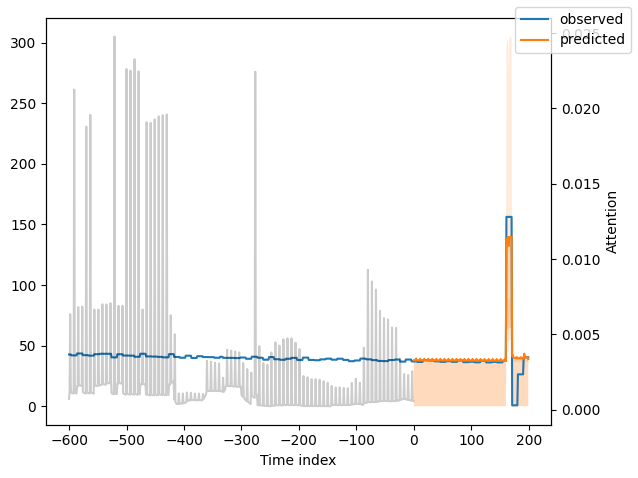

In [17]:
display_model()